In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import KDTree
import time

In [2]:
class obstable:
    def __init__(self, equation):
        # if value of point is < 0 then it is inside the obstacle
        self.equation = equation

    def __call__(self, point):
        return self.equation(point) 
    
class environment:

    def __init__(self, obstacles, dimensions = 2): 
        self.obstacles = [(i,obstacle) for i, obstacle in enumerate(obstacles)]
        self.dimensions = dimensions
    
    def __call__(self, point, return_index = False):
        if len(point) != self.dimensions:
            raise ValueError("Point dimension does not match environment dimension")
        for i,obstacle in self.obstacles:
            if obstacle(point):
                if return_index:
                    return True, i
                else:
                    return True
        return False
    

In [3]:
class PRM :

    def __init__(self, environment, dimensions):
        self.environment = environment
        self.dimensions = dimensions
        self.vertices = []
        self.edges = []
        self.adjacency_list = {}
        self.adjacency_matrix = None

    def sample_points(self, num_samples, range_low, range_high):
        points = np.random.random((num_samples,self.dimensions)) * (range_high - (range_low)) + (range_low)
        for point in points:
            if not self.environment(point):
                self.vertices.append(point)
        
    def connect_nearest_vertices(self,k):
        # creat a KDTree and connect the nearest vertices
        kdtree = KDTree(self.vertices)
        for i, vertex in enumerate(self.vertices):
            dist, index = kdtree.query(vertex, k = k)
            for j in index:
                if i != j:
                    if not self.environment(vertex + (self.vertices[j] - vertex)/2):
                        self.edges.append((i,j))
                        if i in self.adjacency_list:
                            self.adjacency_list[i].append(j)
                        else:
                            self.adjacency_list[i] = [j]
                        if j in self.adjacency_list:
                            self.adjacency_list[j].append(i)
                        else:
                            self.adjacency_list[j] = [i]

    

In [4]:
class RRT:

    def __init__(self, environment, dimensions):
        self.environment = environment
        self.dimensions = dimensions
        self.vertices = []
        self.edges = []
        self.adjacency_list = {}
        self.adjacency_matrix = None
    
    def growTree(self, num_samples, range_low, range_high, start):
        self.vertices.append(start)
        for _ in range(num_samples):
            
            #self.pointsTree = KDTree(self.vertices)
            point = np.random.random((self.dimensions)) * (range_high - (range_low)) + (range_low)
            index = np.argmin(np.linalg.norm(self.vertices - point, axis = 1))
            #dist, index = self.pointsTree.query(point)
            nearest_point = self.vertices[index]
            next_point = nearest_point + 0.2 * (point - nearest_point)/np.linalg.norm(point - nearest_point)
            if not self.environment(point):
                self.vertices.append(next_point)
                self.edges.append((index, len(self.vertices)-1))
                if index in self.adjacency_list:
                    self.adjacency_list[index].append(len(self.vertices)-1)
                else:
                    self.adjacency_list[index] = [len(self.vertices)-1]
                if len(self.vertices)-1 in self.adjacency_list:
                    self.adjacency_list[len(self.vertices)-1].append(index)
                else:
                    self.adjacency_list[len(self.vertices)-1] = [index]

    

In [5]:
square = obstable(lambda point: (max((point[0]), (point[1])) - 1 <=0) and (min((point[0]), (point[1])) >=0 ))
circle = obstable(lambda point: (np.sqrt((point[0]+1.5)**2 + (point[1]+2)**2) - 4 <= 0))
env = environment([square, circle])
prm_model = PRM(env, 2)
t = time.time()
prm_model.sample_points(500, -5, 5)
prm_model.connect_nearest_vertices(6)
print(f'PRM constructed in {time.time() - t}s')
rrt_model = RRT(env, 2)
rrt_model.growTree(500, -5, 5, np.array([2,2]))
print(f'RRT constructed in {time.time() - t}s')


PRM constructed in 0.05487179756164551s
RRT constructed in 0.11061787605285645s


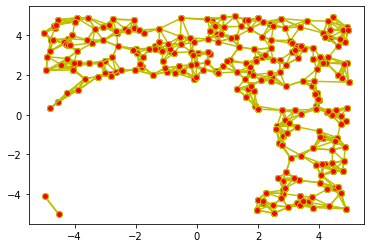

In [6]:
points = np.array(prm_model.vertices)
edges = np.array(prm_model.edges)

x = points[:,0].flatten()
y = points[:,1].flatten()

plt.plot(x[edges.T], y[edges.T], linestyle='-', color='y',
        markerfacecolor='red', marker='o') 

plt.show()

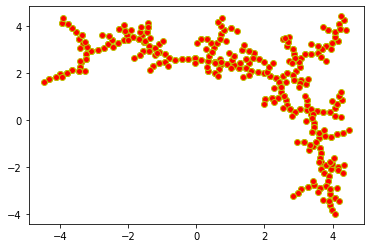

In [7]:
points = np.array(rrt_model.vertices)
edges = np.array(rrt_model.edges)

x = points[:,0].flatten()
y = points[:,1].flatten()

plt.plot(x[edges.T], y[edges.T], linestyle='-', color='y',
        markerfacecolor='red', marker='o') 

plt.show()